In [5]:
!pip install  tensorflow matplotlib

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
!wget -O fruits-360.zip https://github.com/Horea94/Fruit-Images-Dataset/archive/refs/heads/master.zip
!unzip -qq fruits-360.zip

--2025-11-06 05:27:24--  https://github.com/Horea94/Fruit-Images-Dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Horea94/Fruit-Images-Dataset/zip/refs/heads/master [following]
--2025-11-06 05:27:24--  https://codeload.github.com/Horea94/Fruit-Images-Dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip          [       <=>          ] 761.30M  18.3MB/s    in 42s     

2025-11-06 05:28:07 (18.1 MB/s) - ‘fruits-360.zip’ saved [798281972]

replace Fruit-Images-Dataset-master/LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
train_dir = 'Fruit-Images-Dataset-master/Training'
test_dir = 'Fruit-Images-Dataset-master/Test'

IMG_size = (160,160)
BATCH_SIZE = 8

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_size,
    batch_size=BATCH_SIZE,
    shuffle = True
)

Found 67692 files belonging to 131 classes.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_size,
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Detected fruit classes:", num_classes)

Found 22688 files belonging to 131 classes.
Detected fruit classes: 131


In [8]:
from tensorflow.keras.applications.resnet50 import preprocess_input
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y)).shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)


In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers, models
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
base_model.trainable = False
model = models.Sequential([base_model,
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(256, activation='relu'),
                          layers.Dropout(0.3),
                          layers.Dense(num_classes, activation='softmax') ])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 131)            │        33,667 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,145,923 (92.11 MB)

 Trainable params: 558,211 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
8462/8462 ━━━━━━━━━━━━━━━━━━━━ 260s 27ms/step - accuracy: 0.7553 - loss: 1.2023 - val_accuracy: 0.9739 - val_loss: 0.0922
Epoch 2/3
8462/8462 ━━━━━━━━━━━━━━━━━━━━ 263s 30ms/step - accuracy: 0.9975 - loss: 0.0170 - val_accuracy: 0.9822 - val_loss: 0.0593
Epoch 3/3
8462/8462 ━━━━━━━━━━━━━━━━━━━━ 235s 27ms/step - accuracy: 0.9992 - loss: 0.0052 - val_accuracy: 0.9820 - val_loss: 0.0617


Text(0.5, 1.0, 'Accuracy')

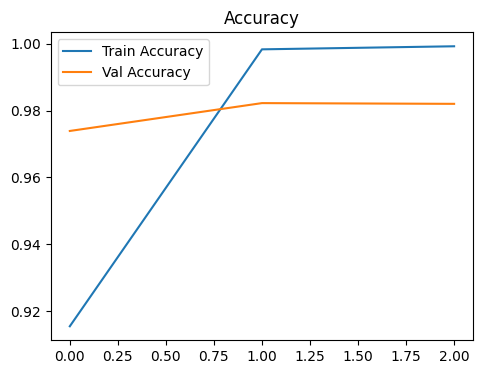

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy')

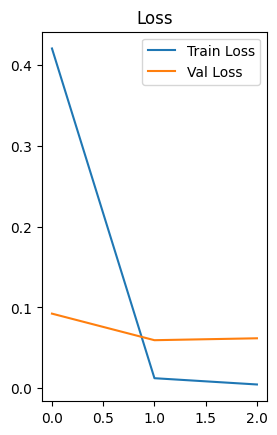

In [12]:
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

In [13]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

2836/2836 ━━━━━━━━━━━━━━━━━━━━ 59s 21ms/step - accuracy: 0.9826 - loss: 0.0592
Test accuracy : 0.982016921043396


Saving images.jpg to images.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


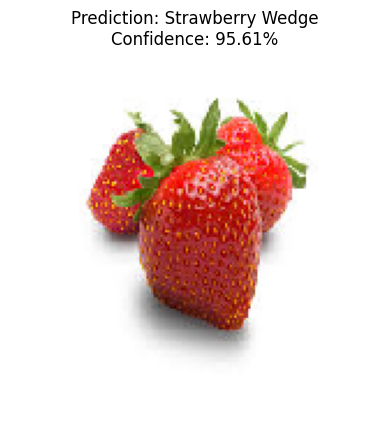

In [17]:
from tensorflow.keras.utils import load_img, img_to_array
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  img = load_img(fn, target_size=IMG_size)
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  predictions = model.predict(img_array)
  label = class_names[np.argmax(predictions)]
  conf = np.max(predictions) * 100

  plt.imshow(img)
  plt.title(f'Prediction: {label}\nConfidence: {conf:.2f}%')
  plt.axis('off')
  plt.show()